In [ ]:
from pvc_tensile_experiment.Functions import *
import numpy as np

# set folder name and directory
folderName = 'Data/PVC P4 Test_0'


# set limits for the search region
smalls = 50
bigs = 2200
openingKernal = np.ones((5,5), np.uint8)

# show the area of the centroids
MarkerIdentify(folderName, smalls, bigs, openingKernal)

# find the tracked particles
tracked = ParticleIdentify(folderName, smalls, bigs, openingKernal)

# process the data and compile, getting strain and stress calculations 
axDist, axStrain, transDist, transStrain, stress  = StrainFunction(folderName, tracked)


596.0
378.0
261.0
456.5
1215.5
792.5
633.5
1205.0


In [ ]:
import matplotlib.pyplot as plt

# copy the data frame so it doesn't get destroyed
objects = tracked.copy()

# list the image names from the directory and separate the data file and images
testName = folderName.split('/')[1]
fileName = os.listdir(folderName)
dataName =  [fileName for fileName in fileName if fileName.endswith('csv')][0]

# all particles should exist in the same frame. remove frames that don't appear 4 times. 
objects.drop(index = objects[objects.particle > 3].index, inplace = True)
objects.reset_index(inplace=True)

# list the particles. if there is more than 4, remove them. find the indices for 
# axial particles using the max and min x-position.  
position = [objects.x[i] for i in objects.particle.unique()]
axParticles = [position.index(max(position)), position.index(min(position))]
transParticles = [int(i) for i in objects.particle.unique() if i not in axParticles]
pair = [axParticles, transParticles] 

# import stress data from the excel sheet but only choose data points that exist in the frames
data = pd.read_csv(f'{folderName}/{dataName}')['Tensile stress'][1::].to_numpy(dtype = float)

# find instanaces where image frames exist and save these isntances of stress data
stressLen = len(data)
frameMax = min([len(objects[objects['particle'] == i]) for i in np.arange(0, 3)])
if stressLen < frameMax:
    stress = data
    frameRange = range(0, stressLen)
elif stressLen > frameMax:
    frameRange = range(0, frameMax)
    stress = np.array(data[frameRange])
else:
    stress = data

# convert the x/y axial and transverse particle to numpy arrays
ax0XPos = objects[objects['particle'] == pair[0][0]].x.to_numpy(dtype = int)[frameRange]
ax0YPos = objects[objects['particle'] == pair[0][0]].y.to_numpy(dtype = int)[frameRange]
ax1XPos = objects[objects['particle'] == pair[0][1]].x.to_numpy(dtype = int)[frameRange]
ax1YPos = objects[objects['particle'] == pair[0][1]].y.to_numpy(dtype = int)[frameRange]
trans0XPos = objects[objects['particle'] == pair[1][0]].x.to_numpy(dtype = int)[frameRange]
trans0YPos = objects[objects['particle'] == pair[1][0]].y.to_numpy(dtype = int)[frameRange]
trans1XPos = objects[objects['particle'] == pair[1][1]].x.to_numpy(dtype = int)[frameRange]
trans1YPos = objects[objects['particle'] == pair[1][1]].y.to_numpy(dtype = int)[frameRange]

# store the x and y positions per particle in an 2D - row array 
ax0 = np.vstack([ax0XPos, ax0YPos])
ax1 = np.vstack([ax1XPos, ax1YPos])
trans0 = np.vstack([trans0XPos, trans0YPos])
trans1 = np.vstack([trans1XPos, trans1YPos])

# define ararys to put distance between axial and transverse markers
axDist = np.zeros(0)
transDist = np.zeros(0)

# calculate the eculidean distance between the particles
for i in range(0, len(ax0XPos)):
    axDist = np.hstack([axDist, np.linalg.norm(ax0[::, i] - ax1[::, i])])
    transDist = np.hstack([transDist, np.linalg.norm(trans0[::, i] - trans1[::, i])])

# calculate engineering strains 
axStrain = abs(axDist - axDist[0])/axDist[0]
transStrain = abs(transDist - transDist[0])/transDist[0]

# preallocate the suplots
fig, axs = plt.subplots(1,2, layout = "constrained")
fig, axs1 = plt.subplots(2,1, layout = "constrained")

# find true strain and stress from engineering strain
stretchRatio = 1 + axStrain
axStrainTrue = np.log(stretchRatio) 
stressTrue = stress*stretchRatio

# plot the engineering axial and transverse strain per frame
axs[0].plot(axStrain, label = 'Axial Strain')
axs[1].plot(transStrain, label = 'Transverse Strain')
axs[0].set_xlabel('Frame')
axs[1].set_xlabel('Frame')
axs[0].set_ylabel('Axial Strain (pxl/pxl)')
axs[1].set_ylabel('Transverse Strain (pxl/pxl)')
axs[0].legend(fontsize = 8)
axs[1].legend(fontsize = 8)

# plot engineering stress-strain and true stress-strain
axs1[0].plot(axStrain, stress)   
axs1[1].plot(axStrainTrue, stressTrue)
axs1[0].set_xlabel('Engineering Strain (pxl/pxl)')
axs1[1].set_xlabel('True Axial Strain (pxl/pxl)')
axs1[0].set_ylabel('Stress (MPa)')
axs1[1].set_ylabel('True Stress (MPa)')
axs1[0].set_title('Engineering Stress-Strain')
axs1[1].set_title('True Stress-Strain')
axs1[0].legend(fontsize = 8)
axs1[1].legend(fontsize = 8)

plt.show()


In [ ]:
'''Marker region adjustment'''
import cv2; import numpy as np

frame = cv2.imread('Data/PVC P2 Test_7/0.jpg')

# blur the image a bit. convert color to hsv from rgb.
blur = cv2.GaussianBlur(frame, (3,3), 0)
hsv = cv2.cvtColor(blur, cv2.COLOR_RGB2HSV)

# select the blue color range which is 95 to 140 hue. openCV uses hue up to 180
upperLim1 = np.array([140, 255, 255])
lowerLim1 = np.array([80, 185, 110]) #90, 110]
mask = cv2.inRange(hsv, lowerLim1, upperLim1)
kernel = np.ones((7,7),np.uint8)
# mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
# mask = cv2.erode(mask, (7,7))


# find the contours from the blue mask
contours, _ = cv2.findContours(mask, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
[print(cv2.contourArea(i)) for i in contours]
cv2.drawContours(frame, contours, -1, (200, 200, 255), 2)
cv2.namedWindow('Inspection', cv2.WINDOW_NORMAL)
cv2.resizeWindow('Inspection', 960, 200)
cv2.imshow('Inspection', frame)
cv2.waitKey(0)
cv2.destroyAllWindows() 

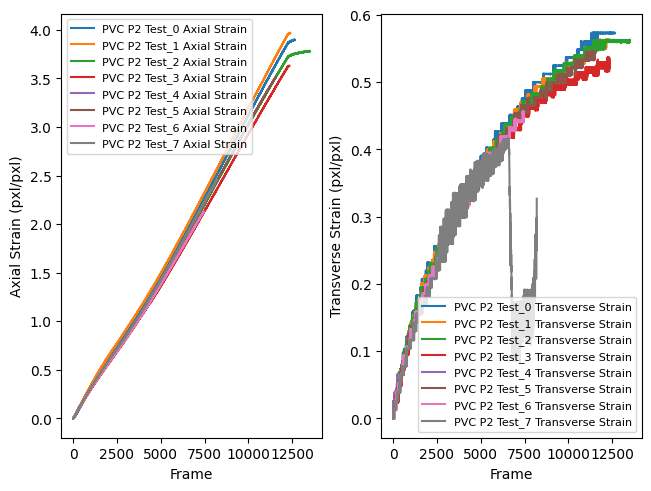

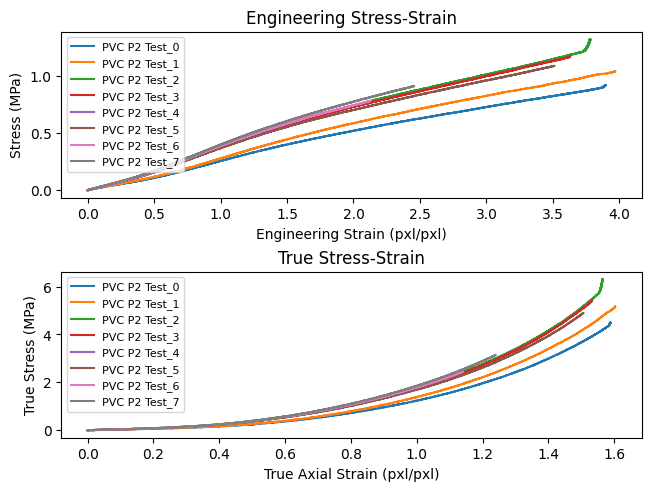

In [2]:
"""Overlay the individual processed data set on a plot"""
from pvc_tensile_experiment.Functions import DataReader
import os; import matplotlib.pyplot as plt
import numpy as np

# the desired plasticizer ratio 
plastiRatio = 'P4'

# list the processed file names
fileNames = [i for i in os.listdir('Processed data') if i.find(f'{plastiRatio}') != -1]

# preallocate the suplots
fig, axs = plt.subplots(1,2, layout = "constrained")
fig, axs1 = plt.subplots(2,1, layout = "constrained")

for i in fileNames:
    name = i.removesuffix('.csv')
    axDist, axStrain, transDist, transStrain, stress = DataReader(i)
    
    # find true strain and stress from engineering strain
    stretchRatio = 1 + axStrain
    axStrainTrue = np.log(stretchRatio) 
    stressTrue = stress*stretchRatio

    # plot the engineering axial and transverse strain per frame
    axs[0].plot(axStrain, label = f'{name} Axial Strain')
    axs[1].plot(transStrain, label = f'{name} Transverse Strain')
    # axs[1].plot(transStrain, axStrain, label = f'{name} Strains' )
    axs[0].set_xlabel('Frame')
    axs[1].set_xlabel('Frame')
    # axs[1].set_xlabel('Transverse Strain (pxl/pxl)')
    axs[0].set_ylabel('Axial Strain (pxl/pxl)')
    axs[1].set_ylabel('Transverse Strain (pxl/pxl)')
    # axs[0].set_ylabel('Strain (pxl/pxl)')
    # axs[1].set_ylabel('Axial Strain (pxl/pxl)')
    axs[0].legend(fontsize = 8)
    axs[1].legend(fontsize = 8)

    # plot engineering stress-strain and true stress-strain
    axs1[0].plot(axStrain, stress, label = f'{name}')   
    axs1[1].plot(axStrainTrue, stressTrue, label = f'{name}')
    axs1[0].set_xlabel('Engineering Strain (pxl/pxl)')
    axs1[1].set_xlabel('True Axial Strain (pxl/pxl)')
    axs1[0].set_ylabel('Stress (MPa)')
    axs1[1].set_ylabel('True Stress (MPa)')
    axs1[0].set_title('Engineering Stress-Strain')
    axs1[1].set_title('True Stress-Strain')
    axs1[0].legend(fontsize = 8)
    axs1[1].legend(fontsize = 8)

plt.show()


In [ ]:
"""Combined elastic modulus and poissons ratio"""
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt; import numpy as np
from pvc_tensile_experiment.Functions import *
import pandas as pd

def LinearFit(x, a, b):
    return a*x + b

# define the plasticizer ration we want
plastiRatio = 'P4'

# compile all the data  
axDist, axStrain, transDist, transStrain, stress = DataComplile(plastiRatio)

# define the elastic region
elasRegion = [list(axStrain).index(i) for i in axStrain if i < 0.2 and i > 0.05]
elasAxStrain = axStrain[elasRegion]
elasTransStrain = transStrain[elasRegion]
elasStress = stress[elasRegion]

# curve fit the elastic region. find the 
xfit = np.linspace(elasAxStrain[0], elasAxStrain[-1])
poptE, pcovE = curve_fit(LinearFit, elasAxStrain, elasStress)
poptP, pcovP = curve_fit(LinearFit, elasAxStrain, elasTransStrain)


# plot engineering stress vs strain
plt.figure(0)
plt.scatter(elasAxStrain, elasStress)
plt.plot(xfit, LinearFit(xfit, poptE[0], poptE[1]), 'r')
plt.xlabel('Axial Strain (pxl/pxl)')
plt.ylabel('Stress (MPa)')
plt.title('Elastic Modulus')
plt.show()

# plot poissons ratio
plt.figure(1)
plt.scatter(elasAxStrain, elasTransStrain)
plt.plot(xfit, LinearFit(xfit, poptP[0], poptP[1]), 'r')
plt.xlabel('Axial Strain (pxl/pxl)')
plt.ylabel('Transverse Strain (pxl/pxl)')
plt.title('Poissons Ratio')
plt.show()

In [ ]:
"""Read the individual processed data sets"""
from pvc_tensile_experiment.Functions import DataReader
axDist, axStrain, transDist, transStrain, stress = DataReader('PVC P4 Test_1.csv')

In [ ]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Sample uniaxial stress and strain data (replace these arrays with your actual data)
true_strain = axStrainTrue # True strain values
stress = stressTrue     # True stress values

# Define the Arruda-Boyce model function for uniaxial stress
def arruda_boyce_model(strain, mu, N):
    # Calculate the stretch ratio, lambda
    lambda_ = 1 + strain
    I1_bar = lambda_**2 + 2 / lambda_

    # Arruda-Boyce uniaxial stress-strain relationship
    return (mu / lambda_) * (lambda_**2 - 1 / lambda_) * (
        1 + (3 / 5) * ((I1_bar - 3) / N) +
        (99 / 175) * ((I1_bar - 3) / N)**2 +
        (513 / 875) * ((I1_bar - 3) / N)**3
    )

# Perform the curve fitting
popt, pcov = curve_fit(arruda_boyce_model, true_strain, stress, p0=[1.0, 5.0])

# Extract the fitted parameters
mu_fitted, N_fitted = popt
print(f"Fitted Arruda-Boyce parameters: mu = {mu_fitted}, N = {N_fitted}")

# Plotting the data and the fitted curve
strain_fit = np.linspace(min(true_strain), max(true_strain), 100)
stress_fit = arruda_boyce_model(strain_fit, mu_fitted, N_fitted)

plt.figure(figsize=(8, 5))
plt.plot(true_strain, stress, 'o', label='Experimental data')
plt.plot(strain_fit, stress_fit, '-', label=f'Arruda-Boyce fit ($\mu$ = {mu_fitted:.3f}, N = {N_fitted:.3f})')
plt.xlabel("True Strain")
plt.ylabel("True Stress")
plt.legend()
plt.title("Arruda-Boyce Hyperelastic Model Fit")
plt.show()

